In [1]:
#!/usr/bin/env python
# coding: utf-8

# Good Old Imports

import os
import sys

import underworld as uw
from underworld import function as fn
import scaling as sca

import glucifer
# import colorcet as cc

# import tokyo
import numpy as np

# import json


#
# Logging, output path and restarting stuff
#

# outputDirName = "dev_py3_TEST_opTe_2x12_512x256"
outputDirName = "2x12_4-00175_THSC_uw27"

outputDir = os.path.join(os.path.abspath("."), outputDirName + "/")
if uw.rank() == 0:
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
uw.barrier()

try:
    fH = open(outputDir + "/checkpoint.log", "r")
except IOError:
    restartFlag = False
    clearLog = True
else:
    lnF = fH.readlines()[-1]
    lC = lnF.split(",")
    rstep = int(lC[0])
    sTime = float(lC[-1].split(";")[0])
    fH.close()
    if rstep <= 1:
        restartFlag = False
        clearLog = False
    else:
        restartFlag = True
        clearLog = False

uw.barrier()

# rstep = 400
# rtimeDm = 0
# clearLog = False
# restartFlag = False
if restartFlag:
    step = rstep

else:
    step = 0
    sTime = 0

maxSteps = step + 3000
steps_output = 10
# timingFlag = uw.__version__.find("2.5") == -1 or uw.__version__.find("2.6") == -1

# # timingFlag
# if timingFlag:
#     uw.timing.start()


if uw.rank() == 0:
    if clearLog:
        logFile = open(outputDir + "/runLog.log", "w+")
    else:
        logFile = open(outputDir + "/runLog.log", "a+")
    if restartFlag:
        logFile.write("\n-------RESTARTING MODEL--------\n")
        logFile.write("\nNprocs:" + str(uw.nProcs()) + "\n")

uw.barrier()

#
# Scaling and Units
#

# Dimentional Parameters
u = sca.UnitRegistry
modelHeight = 2880.0 * u.kilometer
# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 80.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = deltaRhoMax * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

sca.scaling["[length]"] = KL.to_base_units()
# sca.scaling["[temperature]"] = KT.to_base_units()
sca.scaling["[time]"] = Kt.to_base_units()
sca.scaling["[mass]"] = KM.to_base_units()
nd = sca.nonDimensionalize
dm = sca.Dimensionalize

#
# Res and Timing
#

vRes = 64
resMult = 4  # 64 being the base vRes
aRatioMesh = 2  # xRes/yRes
aRatioCoor = 4  # Model len ratio
yRes = int(vRes * resMult)
xRes = int(vRes * aRatioMesh * resMult)
refineHoriz = True
refineVert = True
# refineHoriz = False
# refineVert = False
refInt = [0.00175, 0.00175]
refRange = [0.5, -0.25]

time = nd(sTime * u.megayear)
dt = 0.0
# CFL = 0.1*refInt[1]*yRes
CFL = 1.0

if uw.rank() == 0:
    logFile.write("\n===================================================\n")
    logFile.write("\nNprocs: " + str(uw.nProcs()) + "\n")
    logFile.write("\nRes: {0}x{1} ,CFL: {2}\n".format(xRes, yRes, CFL))
    logFile.write("\nrestartFlag: {0} clearLog:{1} \n".format(restartFlag, clearLog))
    logFile.write("\n(Re)Starting... step={0} at time={1} ".format(step, time))
    logFile.write("\n===================================================\n")
    logFile.close()
# The first solve would be linear, i.e. strainRate_2ndInvariant would be equal to the defaultSRInv
# if(restartFlag):
#     solver_solution_exist = fn.misc.constant(True)
# else:
#     solver_solution_exist = fn.misc.constant(False)
#
# solver_solution_exist.value

mesh = uw.mesh.FeMesh_Cartesian(
    elementType=("Q1/dQ0"),
    elementRes=(xRes, yRes),
    # minCoord=(nd(0.*u.kilometer), nd(-modelHeight+192.*u.kilometer)),
    minCoord=(nd(0.0 * u.kilometer), nd(-modelHeight)),
    # maxCoord=(nd(9600.*u.kilometer), nd(192.*u.kilometer)),
    maxCoord=(aRatioCoor * nd(modelHeight), nd(0.0 * u.kilometer)),
    periodic=[False, False],
)

bBox = ((mesh.minCoord[0], mesh.minCoord[1]), (mesh.maxCoord[0], mesh.maxCoord[1]))
figSize = (1600 * 2, int(1600 / aRatioCoor) * 2 + 110)
# figSize = (1800, 600)

# setupStore = glucifer.Store(outputDir+"/setup")
setupStore = None
figMesh = glucifer.Figure(store=setupStore, figsize=figSize, quality=3)
figMesh.Mesh(mesh)
# # figMesh.save()
figMesh.save(outputDir + "/MeshInit2.png")

if restartFlag is False:
    if uw.rank() == 0:
        print("Deforming Mesh.....!")

    xO = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
    cenX = (mesh.maxCoord[0] - mesh.minCoord[0]) / 2
    xL = np.arange(cenX, cenX + refRange[0] / 2.0, refInt[0])
    xG = np.geomspace(
        cenX + refRange[0] / 2, mesh.maxCoord[0], mesh.elementRes[0] / 2.0 - xL.size + 1
    )
    # xG = np.linspace(
    #     cenX + refRange[0]/2, mesh.maxCoord[0], mesh.elementRes[0]/2. - xL.size+1)
    assert mesh.elementRes[0] / 2 - (xL.size + xG.size) == -1
    xR = np.concatenate((xL, xG), axis=0)
    xrF = np.flip((mesh.maxCoord[0] - mesh.minCoord[0]) - xR, axis=0)
    xR = np.concatenate((xrF, xR), axis=0)
    xR = np.delete(xR, xR.size / 2)
    assert mesh.elementRes[0] + 1 - xR.size == 0

    yO = np.linspace(mesh.minCoord[1], mesh.maxCoord[1], mesh.elementRes[1] + 1)
    yL = np.arange(mesh.maxCoord[1], mesh.maxCoord[1] + refRange[1], -refInt[1])
    yG = np.geomspace(
        mesh.maxCoord[1] + refRange[1], mesh.minCoord[1], yO.size - yL.size
    )
    # yG = np.linspace(mesh.maxCoord[1] + refRange[1],
    #                  mesh.minCoord[1], yO.size - yL.size)
    assert mesh.elementRes[1] + 1 - (yL.size + yG.size) == 0
    yR = np.concatenate((yL, yG), axis=0)
    yR = np.flip(yR, axis=0)  # -ve Coordinates silly hack for interp

    uw.barrier()  # safeguard
    # xM, yM = np.meshgrid(xR, yR)
    mesh.reset()
    with mesh.deform_mesh():
        if refineHoriz:
            mesh.data[:, 0] = np.interp(mesh.data[:, 0], xO, xR)
        if refineVert:
            mesh.data[:, 1] = np.interp(mesh.data[:, 1], yO, yR)
    uw.barrier()  # safeguard
    # setupStore.step = 1
    # figMesh.save()
    figMesh.save(outputDir + "/MesHRef.png")

    if uw.rank() == 0:
        print("Deforming Mesh......Done!")

velocityField = mesh.add_variable(nodeDofCount=mesh.dim)
pressureField = mesh.subMesh.add_variable(nodeDofCount=1)

uw.barrier()  # Just to be safe that all the vars sync

# SO MUCH FOR A MONOLITHIC FILE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! people dont care about good modular code? why should I.
# IDEA: the worst thing to do is write a monolithic file with future modularity in mind
# The Good old "Should work for now"

# Separating these only because these two take significantly different time, faster swarm loads = LoL!


def load_mesh_vars(step):
    if uw.rank() == 0:
        print("Loading Mesh.....")
    mh = mesh.load(outputDir + "/mesh.00000.h5")
    velocityField.load(outputDir + "velocityField." + str(step).zfill(5) + ".h5")
    pressureField.load(outputDir + "pressureField." + str(step).zfill(5) + ".h5")
    if uw.rank() == 0:
        print("Loading Mesh......Done!")
    return mesh.save(outputDir + "mesh.00000.h5")
    # return uw.utils.SavedFileData(mh, outputDir+'/mesh.00000.h5')


# Being Very Explict about True and False!!!!!!

if restartFlag is False:
    velocityField.data[:] = [0.0, 0.0]
    pressureField.data[:] = 0.0
    uw.barrier()  # This is weirdly IMPORTANT
    meshHnd = mesh.save(outputDir + "mesh.00000.h5")
if restartFlag is True:
    meshHnd = load_mesh_vars(step=rstep)

# The Boundaries: "I'll stay awake cause the dark's not taking prisoners tonight"

iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition(
    variable=velocityField, indexSetsPerDof=(iWalls, jWalls)
)
# Setup Swarms TODO: split thresholds

swarm = uw.swarm.Swarm(mesh=mesh)

materialVariable = swarm.add_variable(dataType="int", count=1)


def load_swarm_vars(step):
    if uw.rank() == 0:
        print("Loading Swarm.....")
    swarm.load(outputDir + "swarm." + str(step).zfill(5) + ".h5")
    materialVariable.load(outputDir + "materialVariable." + str(step).zfill(5) + ".h5")
    swarm_popcontrol.repopulate()
    if uw.rank() == 0:
        print("Loading Swarm......Done!")


# swarmviscosityVar = swarm.add_variable(dataType="double", count=1)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=swarm, particlesPerCell=20
)
# Do not populate while restarting
if restartFlag is False:
    swarm.populate_using_layout(layout=swarmLayout)

swarm_popcontrol = uw.swarm.PopulationControl(
    swarm,
    deleteThreshold=0.0025,
    splitThreshold=0.10,
    maxDeletions=0,
    maxSplits=100,
    aggressive=True,
    aggressiveThreshold=0.95,
    particlesPerCell=20,
)

# (swarm,deleteThreshold=0.,splitThreshold=0.,maxDeletions=0,maxSplits=9999)
# create checkpoint function _ adapted from
# https://github.com/underworldcode/underworld2/blob/regionalMesh/docs/development/models_inprogress/annulus/examples/stokes_hemisphere.ipynb


def checkpoint(step, time):
    # save swarm and swarm variables

    swarmHnd = swarm.save(outputDir + "swarm." + str(step).zfill(5) + ".h5")
    materialVariableHnd = materialVariable.save(
        outputDir + "materialVariable." + str(step).zfill(5) + ".h5"
    )
    # save mesh variables
    velocityHnd = velocityField.save(
        outputDir + "velocityField." + str(step).zfill(5) + ".h5", meshHnd
    )
    pressureHnd = pressureField.save(
        outputDir + "pressureField." + str(step).zfill(5) + ".h5", meshHnd
    )
    projVisMesh.solve()
    projViscHnd = projVisc.save(
        outputDir + "projVisc." + str(step).zfill(5) + ".h5", meshHnd
    )
    # and the xdmf files
    materialVariable.xdmf(
        outputDir + "materialVariable." + str(step).zfill(5) + ".xdmf",
        materialVariableHnd,
        "materialVariable",
        swarmHnd,
        "swarm",
        modeltime=time,
    )
    velocityField.xdmf(
        outputDir + "velocityField." + str(step).zfill(5) + ".xdmf",
        velocityHnd,
        "velocity",
        meshHnd,
        "mesh",
        modeltime=time,
    )
    pressureField.xdmf(
        outputDir + "pressureField." + str(step).zfill(5) + ".xdmf",
        pressureHnd,
        "pressure",
        meshHnd,
        "mesh",
        modeltime=time,
    )
    projVisc.xdmf(
        outputDir + "projViscField." + str(step).zfill(5) + ".xdmf",
        projViscHnd,
        "projVisc",
        meshHnd,
        "mesh",
        modeltime=time,
    )
    uw.barrier()
    # Write checkpoint log only after files have been generated
    if uw.rank() == 0:
        checkpointlogFile = open(outputDir + "/checkpoint.log", "a+")
        checkpointlogFile.write("{0:6d},{1};\n".format(step, time))
        checkpointlogFile.close()


# function for the shapes


def make_slab2d(topX, topY, length, taper, dip, depth, thicknessArray):
    d = topY
    ts = thicknessArray
    noSlabs = len(ts)
    totalThickness = sum(ts)
    polyshapes = []
    for i in range(noSlabs):
        polyshapes.append(
            [
                (topX, topY),
                (topX + totalThickness / (np.tan(np.radians(taper))), d),
                (topX + length, d),
                (topX + length + depth / np.tan(np.radians(dip)), d - depth),
                (topX + length + depth / np.tan(np.radians(dip)), d - depth - ts[i]),
                (topX + length, d - ts[i]),
                (topX + totalThickness / np.tan(np.radians(taper)), d - ts[i]),
            ]
        )
        d -= ts[i]

    return polyshapes


def make_Indentor2d(startX, topY, length, taper, thicknessArray, taper2=None):
    if taper2 is None:
        taper2 = taper
    d = topY
    ts = thicknessArray
    noSlabs = len(ts)
    polyshapes = []
    # xs = ts[0]/np.tan(np.radians(taper))
    for i in range(noSlabs):
        polyshapes.append(
            [
                [startX - d / np.tan(np.radians(taper2)), topY + d],
                [startX + length + d / np.tan(np.radians(taper)), topY + d],
                [
                    startX + length + (d - ts[i]) / np.tan(np.radians(taper)),
                    topY + d - ts[i],
                ],
                [startX - (d - ts[i]) / np.tan(np.radians(taper2)), topY + d - ts[i]],
            ]
        )
        d -= ts[i]

    # polyshapes[0][0][0] = polyshapes[0][0][0]+2*xs
    # polyshapes[0][1][0] = polyshapes[0][1][0]-2*xs
    return polyshapes


def make_overRidingPlate2d(topX, topY, length, taper, dip, thicknessArray):
    d = topY
    ts = thicknessArray
    noPlates = len(ts)
    totalThickness = sum(ts)
    polyshapes = []
    for i in range(noPlates):
        polyshapes.append(
            [
                (topX, topY),
                (topX + totalThickness / np.tan(np.radians(taper)), topY + d),
                (topX + length - d / np.tan(np.radians(dip)), topY + d),
                (
                    topX + length + (ts[i] - d) / np.tan(np.radians(dip)),
                    topY - ts[i] + d,
                ),
                (topX + totalThickness / np.tan(np.radians(taper)), topY - ts[i] + d),
            ]
        )
        d -= ts[i]
    return polyshapes


def make_layer2d(startX, topY, length, thicknessArray):
    d = topY
    ts = thicknessArray
    noSlabs = len(ts)
    polyshapes = []
    for i in range(noSlabs):
        polyshapes.append(
            [
                (startX, d),
                (startX + length, d),
                (startX + length, d - ts[i]),
                (startX, d - ts[i]),
            ]
        )
        d -= ts[i]
    return polyshapes


# Shape Up the Geomotries TODO: Dimentional Coordinates
# mantleandAirShape = make_layer2d(startX=0.,
#                                  topY=mesh.maxCoord[1],
#                                  length=nd(9600.*u.kilometer),
#                                  thicknessArray=[nd(modelHeight)])
# # thicknessArray=[nd(192.*u.kilometer), nd(modelHeight-192.*u.kilometer)])
mantleShape = make_layer2d(
    startX=0.0,
    topY=0.0,
    length=nd(modelHeight * aRatioCoor),
    thicknessArray=[nd(modelHeight)],
    # thicknessArray=[nd(660.*u.kilometer), nd(modelHeight-660.*u.kilometer)]
)

slabshapes = make_slab2d(
    topX=nd(0.725 * modelHeight),
    topY=0.0,
    length=nd(1.275 * modelHeight),
    taper=15,
    dip=29,
    depth=nd(120.0 * u.kilometer),
    thicknessArray=[
        nd(15.0 * u.kilometer),
        nd(15.0 * u.kilometer),
        nd(30.0 * u.kilometer),
        nd(30.0 * u.kilometer),
    ],  # thic # 10 20 20 30
)

indentorshapes = make_Indentor2d(
    startX=nd(0.3 * modelHeight),
    topY=nd(0.0 * u.kilometer),
    length=nd(0.85 * modelHeight),
    taper=18,
    thicknessArray=[
        nd(15.0 * u.kilometer),
        nd(15.0 * u.kilometer),
        nd(30.0 * u.kilometer),
        nd(30.0 * u.kilometer),
    ],  # UL
    taper2=12,
)

overRidingShapesForeArc = make_overRidingPlate2d(
    topX=mesh.maxCoord[0] - mesh.minCoord[0],
    topY=nd(0.0 * u.kilometer),
    length=-nd(2.0 * modelHeight),
    taper=15,
    dip=29,
    thicknessArray=[nd(40.0 * u.kilometer), nd(80.0 * u.kilometer)],
)

overRidingShapes = make_overRidingPlate2d(
    topX=mesh.maxCoord[0] - mesh.minCoord[0],
    topY=nd(0.0 * u.kilometer),
    length=nd(-1.875 * modelHeight),
    taper=90,
    dip=90,
    thicknessArray=[nd(40.0 * u.kilometer), nd(80.0 * u.kilometer)],
)
# define the viscosity Range
viscRange = [1.0, 1e5]


def viscosity_limit(viscosityFn, viscosityRange=viscRange):
    return fn.misc.max(viscosityRange[0], fn.misc.min(viscosityRange[1], viscosityFn))


# the default strain rate Invariant used for the initial visc
defaultSRInv = nd(1e-18 / u.second)
strainRate = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)


def yield_visc(cohesion, viscosity):
    eII = strainRate_2ndInvariant
    etaVp = fn.exception.SafeMaths(
        fn.misc.min(cohesion / (2.0 * (eII + defaultSRInv)), viscosity)
    )
    return viscosity_limit(etaVp)


# depthViscosityfn = fn.branching.conditional([(fn.coord()[1] > nd(-660.*u.kilometer), 1.), (True, 1e2)])
def depthViscosityfn(viscosity0, viscosity1, depth, coordtype=None):
    if isinstance(viscosity0, u.Quantity):
        viscosity0 = nd(viscosity0)
    if isinstance(viscosity1, u.Quantity):
        viscosity1 = nd(viscosity1)

    return fn.branching.conditional(
        [(fn.coord()[1] > nd(depth), viscosity0), (True, viscosity1)]
    )


modelMaterials = [
    # {"name": "Air",
    #  "shape": mantleandAirShape[0],
    #  "viscosity":0.1*refViscosity,
    #  "density":0.*u.kilogram / u.meter**3},
    {
        "name": "Mantle",
        "shape": mantleShape[0],
        "viscosity": "deptDependent",
        "eta0": refViscosity,
        "eta1": 1e2 * refViscosity,
        "etaChangeDepth": 660.0 * u.kilometer,
        "density": "deptDependent",
        "rho0": 3200.0 * u.kilogram / u.meter ** 3,
        "rho1": 3230.0 * u.kilogram / u.meter ** 3,
        "rhoChangeDepth": 660.0 * u.kilometer,
    },
    # {"name": 'Upper Mantle',
    #  "shape": mantleShape[0],
    #  "viscosity":1*refViscosity,
    #  "density":3200.*u.kilogram / u.meter**3},
    # {"name": 'Lower Mantle',
    #  "shape": mantleShape[1],
    #  "viscosity":1e2*refViscosity,
    #  "density":3240.*u.kilogram / u.meter**3},
    # Indo-Australian Plate `4 plates`
    {
        "name": "Uppper Crust Indo-Australian Plate",
        "shape": slabshapes[0],
        "viscosity": 1e2 * refViscosity,
        "cohesion": 06.0 * u.megapascal,
        # "viscosity":"deptDependent",
        # "eta0":yield_visc(nd(06.*u.megapascal), nd(1e2*refViscosity)),
        # "eta1":yield_visc(nd(30.*u.megapascal), nd(5e1*refViscosity)),  # 5e1
        # "etaChangeDepth":150.*u.kilometer,
        "density": 3280.0 * u.kilogram / u.meter ** 3,
    },
    {
        "name": "Lower Crust Indo-Australian Plate",
        "shape": slabshapes[1],
        "viscosity": 1e3 * refViscosity,
        "cohesion": 30.0 * u.megapascal,
        "density": 3280.0 * u.kilogram / u.meter ** 3,
    },  # 5.*u.megapascal,
    {
        "name": "Lithospheric Mantle Crust Indo-Australian Plate",
        "shape": slabshapes[2],
        "viscosity": 1e5 * refViscosity,
        "cohesion": 400.0 * u.megapascal,  # hs
        "density": 3280.0 * u.kilogram / u.meter ** 3,
    },
    {
        "name": "Lithospheric Mantle Indo-Australian Plate",
        "shape": slabshapes[3],
        "viscosity": 5e2 * refViscosity,
        "density": 3280.0 * u.kilogram / u.meter ** 3,
        "cohesion": 30.0 * u.megapascal,
    },
    # Indian Indentor
    {
        "name": "Upper Crust Indian Indentor",
        "shape": indentorshapes[0],
        # "viscosity":"deptDependent",
        # "eta0":yield_visc(nd(06.*u.megapascal), nd(1e2*refViscosity)),  # 1e2
        # "eta1":yield_visc(nd(30.*u.megapascal), nd(5e1*refViscosity)),  # 5e1
        # "etaChangeDepth":150.*u.kilometer,
        "viscosity": 1e2 * refViscosity,
        "cohesion": 06.0 * u.megapascal,
        "density": 2800.0 * u.kilogram / u.meter ** 3,
        # "density":"deptDependent",
        # "rho0":2800.*u.kilogram / u.meter**3,
        # "rho1":3280.*u.kilogram / u.meter**3,
        # "rhoChangeDepth":150.*u.kilometer
    },
    {
        "name": "Lower Crust Indian Indentor",
        "shape": indentorshapes[1],
        "viscosity": 1e2 * refViscosity,
        "cohesion": 30.0 * u.megapascal,
        "density": 2800.0 * u.kilogram / u.meter ** 3,
        # "density":"deptDependent",
        # "rho0":2800.*u.kilogram / u.meter**3,
        # "rho1":3280.*u.kilogram / u.meter**3,
        # "rhoChangeDepth":150.*u.kilometer
    },
    {
        "name": "Lithospheric Mantle Indian Indentor",
        "shape": indentorshapes[2],
        "viscosity": 1e5 * refViscosity,
        "cohesion": 400.0 * u.megapascal,
        "density": 3200.0 * u.kilogram / u.meter ** 3,
        # "density":"deptDependent",
        # "rho0":3200.*u.kilogram / u.meter**3,
        # "rho1":3280.*u.kilogram / u.meter**3,
        # "rhoChangeDepth":150.*u.kilometer
    },
    {
        "name": "Lithospheric Mantle Indian Indentor",
        "shape": indentorshapes[3],
        "viscosity": 5e4 * refViscosity,
        "cohesion": 30.0 * u.megapascal,
        "density": 3220.0 * u.kilogram / u.meter ** 3
        # "density":"deptDependent",
        # "rho0":3220.*u.kilogram / u.meter**3,
        # "rho1":3280.*u.kilogram / u.meter**3,
        # "rhoChangeDepth":150.*u.
    },
    # Eurasian Plate
    {
        "name": "Crust Eurasian Plate ForeArc",
        "shape": overRidingShapesForeArc[0],
        "viscosity": 1e3 * refViscosity,
        "density": 3200.0 * u.kilogram / u.meter ** 3,
    },
    {
        "name": "Lithospheric Mantle Eurasian Plate ForeArc",
        "shape": overRidingShapesForeArc[1],
        "viscosity": 5e2 * refViscosity,
        "density": 3200.0 * u.kilogram / u.meter ** 3,
    },
    {
        "name": "Crust Eurasian Plate",
        "shape": overRidingShapes[0],
        "viscosity": 5e2 * refViscosity,
        "density": 3200.0 * u.kilogram / u.meter ** 3,
    },
    {
        "name": "Lithospheric Mantle Eurasian Plate",
        "shape": overRidingShapes[1],
        "viscosity": 2e2 * refViscosity,
        "density": 3200.0 * u.kilogram / u.meter ** 3,
    },
]
# figSize = (1800, 700)  # Chota ;)

# if uw.rank() == 0:
#     with open(outputDir+'modelMaterials.json', 'w+') as file:
#         file.write(json.dumps(modelMaterials))
#         file.close()

if restartFlag is False:
    for i, mat in enumerate(modelMaterials):
        if mat.get("shape"):
            condition = [
                (fn.shape.Polygon(np.array(mat["shape"])), i),
                (True, materialVariable),
            ]
            func = fn.branching.conditional(condition)
            materialVariable.data[:] = func.evaluate(swarm)
if restartFlag is True:
    load_swarm_vars(step=rstep)

# store = glucifer.Store(outputDir+'/ieaHR')
store = None
figParticle = glucifer.Figure(
    store, figsize=figSize, name="Materials", boundingBox=bBox
)
figParticle.Points(
    swarm,
    materialVariable,
    pointsize=1.9,
    discrete=True,
    colours="paired",
    fn_mask=materialVariable > 0,
    valueRange=[1, len(modelMaterials) - 1],
)
figParticle.objects[0].colourBar["binlabels"] = True
figParticle.objects[0].colourBar["size"] = [0.8, 0.02]
if restartFlag is False:
    figParticle.save(outputDir + "/Particles_Initial")
# figParticle.show()

# ### Passive Tracer Tests
# %matplotlib
# import matplotlib.pyplot as plt
# for i, mat in enumerate(modelMaterials):
#     ma = np.array(mat["shape"])
#     print np.max(mat["shape"][1])
#     print np.min(mat["shape"][1])
#     plt.scatter(ma)
# ####
# plt.gca().invert_yaxis()
#
# plt.show()
# ma = np.array(mat["shape"])
# ma.max()
# ma[:, 1]
# pass
# WIP! check for the scaling of the exponent
# def power_visc(eta0, n):
#     return fn.math.exp(2. * (strainRate_2ndInvariant), 1.0/n - 1.0) * fn.math.exp(eta0, 1.0/n)

# powervfn = viscosity_limit(power_visc(1.5e-7, 3.5), viscRange)
# figViscosity = glucifer.Figure(store, figsize=figSize, name="Viscosity Map")

viscosityMap = {
    i: yield_visc(nd(mat["cohesion"]), nd(mat["viscosity"]))
    if mat.get("cohesion")
    else depthViscosityfn(mat["eta0"], mat["eta1"], -mat["etaChangeDepth"])
    if mat["viscosity"] == "deptDependent"
    else nd(mat["viscosity"])
    for (i, mat) in enumerate(modelMaterials)
}
viscosityMapFn = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap)

# figViscosity = glucifer.Figure(
#     store, figsize=figSize,  name="Viscosity_Map", title="Viscosity_Map")
# # davos.cm_data.reverse()

# figViscosity.Points(swarm,
#                     viscosityMapFn,
#                     pointsize=1.9, logScale=True,
#                     # colours=davos.cm_data,
#                     # valueRange=[1e-3, 1e4],
#                     colours="(0.001)Cyan (0.01)Green (0.1)ForestGreen (1.0)Grey (10.0)Orange (100.0)Brown (1000.0)Blue (10000.0)Black"
#                     )
# figViscosity.objects[0].colourBar["tickvalues"] = [
#     1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 4e2, 1e4, 1e5, 1e6]
# # swarmviscosityVar = viscosityMapFn.evaluate(swarm)
#
# if restartFlag is False:
#     figViscosity.save(outputDir+figViscosity["title"])
# figViscosity.save()

projVisc = mesh.add_variable(1)
projVisMesh = uw.utils.MeshVariable_Projection(projVisc, viscosityMapFn, type=0)
projVisMesh.solve()
from colorMaps import coldmorning as coldmorning

# vlike.cm_data.reverse()
figViscosityMesh = glucifer.Figure(store, figsize=figSize, name="Viscosity Map")
figViscosityMesh.Surface(
    mesh,
    projVisc,
    logScale=True,
    onMesh=True,
    valueRange=[0.1, 1e4],
    colours=coldmorning.cm_data,
    # valueRange=viscRange,
    # colours=vlike.cm_data,
    # colours=glucifer.lavavu.matplotlib_colourmap(
    #     "magma_r")
)
# colours="Cyan Green ForestGreen Grey Orange Brown Blue Black")
# figViscosityMesh.Mesh(mesh)

figViscosityMesh.objects[0].colourBar["tickvalues"] = np.logspace(-2, 4, 7).tolist()
if restartFlag is False:
    figViscosityMesh.save(outputDir + "/ViscosityMesh_Initial_3")

# refDensity = 2500.*u.kilogram / u.meter**3


def depthDensityfn(density0, density1, depth):
    # densityfn == 0
    return fn.branching.conditional(
        [
            (fn.coord()[1] > nd(depth), nd(density0 - refDensity)),
            (True, nd(density1 - refDensity)),
        ]
    )


densityMap = {
    # i: (nd(mat["density"])-nd(refDensity))/nd(delta_rhoMax)for(i, mat) in enumerate(modelMaterials)}
    i: depthDensityfn(mat["rho0"], mat["rho1"], -mat["rhoChangeDepth"])
    if mat["density"] == "deptDependent"
    else nd(mat["density"] - refDensity)
    for (i, mat) in enumerate(modelMaterials)
}

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)
z_hat = (0.0, -1.0)
buoyancyFn = densityFn * z_hat * nd(gravity)

sf = sca.Dimensionalize(1.0, 1.0 * u.kilogram / u.meter ** 3)

figDensity = glucifer.Figure(
    store, figsize=figSize, name="Density Map", boundingBox=bBox
)
figDensity.Points(
    swarm,
    densityFn * sf.magnitude + refDensity.magnitude,
    valueRange=[2800, 3280],
    fn_mask=materialVariable > 0,
    pointsize=1.9,
    colours="spectral",
)

figDensity.objects[0].colourBar["tickvalues"] = [2800, 2900, 3000, 3100, 3200, 3280]
if restartFlag is False:
    figDensity.save(outputDir + "/Density_Initial")
# figDensity.save()

figbuoyancy = glucifer.Figure(figsize=figSize, name="Buoyancy Map")
figbuoyancy.Points(
    swarm,
    densityFn * nd(gravity),
    pointsize=3,
    colours="Black Blue (0.00)white Green Red"
    # colours=list(glucifer.lavavu.matplotlib_colourmap("Accent")),
)
figbuoyancy.objects[0].colourBar["tickvalues"] = [-5, -0.25, 0.0, 0.25, 0.5, 1]
if restartFlag is False:
    figbuoyancy.save(outputDir + "/figbuoyancy")

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[freeslipBC],
    fn_viscosity=viscosityMapFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

if uw.nProcs() == 1:
    solver.set_inner_method("lu")
else:
    solver.set_inner_method("mumps")

# solver.options.scr.ksp_type = "cg"
solver.set_penalty(1e5)

# solver.options.main.remove_checkerboard_pressure_null_space = True

solver.options.A11.ksp_rtol = 1e-4
solver.options.scr.ksp_rtol = 1e-4

# solver.options.scr.use_previous_guess = True
# solver.options.scr.ksp_set_min_it_converge = 3

# #Set more advanced solver option
# solver.options.main.Q22_pc_type='gkgdiag'
# # solver.options.A11.ksp_rtol=1e-2
# # solver.options.scr.ksp_rtol=1e-3
solver.options.A11.ksp_type = "cg"
solver.options.scr.use_previous_guess = True
# #solver.options.scr.ksp_set_min_it_converge = 1
# #solver.options.main.penalty=10.0
#
# solver.options.mg.levels = 2
# #solver.options.main.remove_constant_pressure_null_space=True
# #solver.options.main.penalty = 1e2
#
# solver.options.A11.ksp_rtol=1e-4
# solver.options.scr.ksp_rtol=1e-4
#
# solver.options.A11.ksp_monitor = 'ascii'
# # solver.options.A11.ksp_converged_reason=''

advector = uw.systems.SwarmAdvector(swarm=swarm, velocityField=velocityField, order=2)

vdotv = fn.math.dot(velocityField, velocityField)
figVelocityMag = glucifer.Figure(store, figsize=figSize, name="Velocity Magnitude")
# tokyo.cm_data.reverse()
figVelocityMag.Surface(
    mesh,
    fn.math.sqrt(fn.math.dot(velocityField, velocityField)),
    # valueRange=[0, 1e-4],
    # logScale=True,
    # colours=glucifer.lavavu.matplotlib_colourmap(
    # "plasma_r"),
    # colours=tokyo.cm_data,
    onMesh=True,
)
figVelocityMag.save()

figStrainRate = glucifer.Figure(store, figsize=figSize, name="Strain Rate")
figStrainRate.Surface(
    mesh,
    strainRate_2ndInvariant,
    logScale=True,
    valueRange=[1e-7, 1e-2],
    colours="cubelaw2",
    # colours=glucifer.lavavu.matplotlib_colourmap("viridis")
    onMesh=True,
)
figStrainRate.objects[0].colourBar["tickvalues"] = [2e-6, 1e-5, 1e-4, 1e-3, 1e-2]
if restartFlag is False:
    figStrainRate.save()

# solver.solve(nonLinearIterate=False)

# figPressure = glucifer.Figure(
#     store, figsize=figSize,  Name="Pressure Map")
# figPressure.Surface(mesh,
#                     pressureField,
#                     colours=glucifer.lavavu.matplotlib_colourmap("inferno_r"),
#                     onMesh=True)
# if restartFlag is False:
#     figPressure.save()

viscStress = 2.0 * viscosityMapFn * strainRate
# figStress = glucifer.Figure(store, name="Stress", figsize=figSize,quality=3)
# figStress.append(glucifer.objects.Points(
#     swarm, 2.0*viscosityMapFn*strainRate_2ndInvariant, pointSize=2, logScale=True))
# figStressXX = glucifer.Figure(
#     store, name="Stress_XX", figsize=figSize, quality=3)
# figStressXX.append(glucifer.objects.Points(
#     swarm, viscStress[0], pointsize=2, colours='spectral'))
# figStress.save()

top = mesh.specialSets["MaxJ_VertexSet"]
surfaceArea = uw.utils.Integral(
    fn=1.0, mesh=mesh, integrationType="surface", surfaceIndexSet=top
)
surfacePressureIntegral = uw.utils.Integral(
    fn=pressureField, mesh=mesh, integrationType="surface", surfaceIndexSet=top
)

# a callback function to calibrate the pressure - will pass to solver later
NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)


def smooth_pressure():
    if uw.rank() == 0:
        print("Smoothing Pressure...")
    Cell2Nodes.solve()
    Nodes2Cell.solve()


def pressure_calibrate():
    if uw.rank() == 0:
        print("Calibration and Smoothing of PressureField... ")
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0 / area
    if uw.rank() == 0:
        print("Zeroing pressure using mean upper surface pressure {}".format(offset))
    pressureField.data[:] -= offset
    smooth_pressure()
    if uw.rank() == 0:
        print("Calibration and Smoothing of PressureField... Done")
    sys.stdout.flush()


def output_figures(step):
    # store.step = step
    # figParticle.save(outputDir + "particle" + str(step).zfill(4))
    projVisMesh.solve()
    figViscosityMesh.save_image(outputDir + "viscosity" + str(step).zfill(5))

    figVelocityMag.save_image(outputDir + "velocityMag" + str(step).zfill(5))
    figStrainRate.save(outputDir + "strainRate" + str(step).zfill(5))
    figDensity.save_image(outputDir + "density" + str(step).zfill(5))
    # figViscosity.save_image(outputDir + "viscosity" + str(step).zfill(5))
    # # figStress.save(outputDir + "stress" + str(step).zfill(4))
    # figStressXX.save(outputDir + "Stress_XX" + str(step).zfill(4))
    # # figPressure.save(outputDir + "pressure" + str(step).zfill(4))
    #
    # figParticle.save()
    # figVelocityMag.save()
    # figStrainRate.save()
    # figViscosity.save()
    # # figStress.save(outputDir + "stress" + str(step).zfill(4))
    # figStressXX.save()
    # figPressure.save()


def model_update():
    # swarm_popcontrol.repopulate()
    dt = advector.get_max_dt()
    uw.barrier()
    if uw.rank() == 0:
        print("Advecting Particles...")

    dt *= CFL
    advector.integrate(dt)
    uw.barrier()
    # Cheap and Ugly Phase Change
    # material_flags = swarm.particleCoordinates.data[:, 1] < -nd(660.*u.kilometer)
    # upperMantleGoingBelow = np.logical_and(np.in1d(materialVariable.data, 0), material_flags)
    # materialVariable.dasta[upperMantleGoingBelow] = 1
    # lowerMantelGoingUp = np.logical_and(np.in1d(materialVariable.data, 1), ~material_flags)
    # materialVariable.data[lowerMantelGoingUp] = 0
    if uw.rank() == 0:
        print("Repopulating Particles...")
    swarm_popcontrol.repopulate()

    if step % steps_output == 0 or step == maxSteps - 1:
        output_figures(step)

    return time + dt, step + 1, dt


# solver.solve(nonLinearIterate=False,
#              callback_post_solve=pressure_calibrate)
#
# fieldDict = {'velocity': velocityField,
#             'pressure': pressureField}
#
# swarmDict = {'materials': materialVariable,
#             'viscosity': swarmviscosityVar}
if restartFlag is False:
    checkpoint(step=0, time=dm(time, 1.0 * u.megayear).magnitude)



Deforming Mesh.....!
Deforming Mesh......Done!


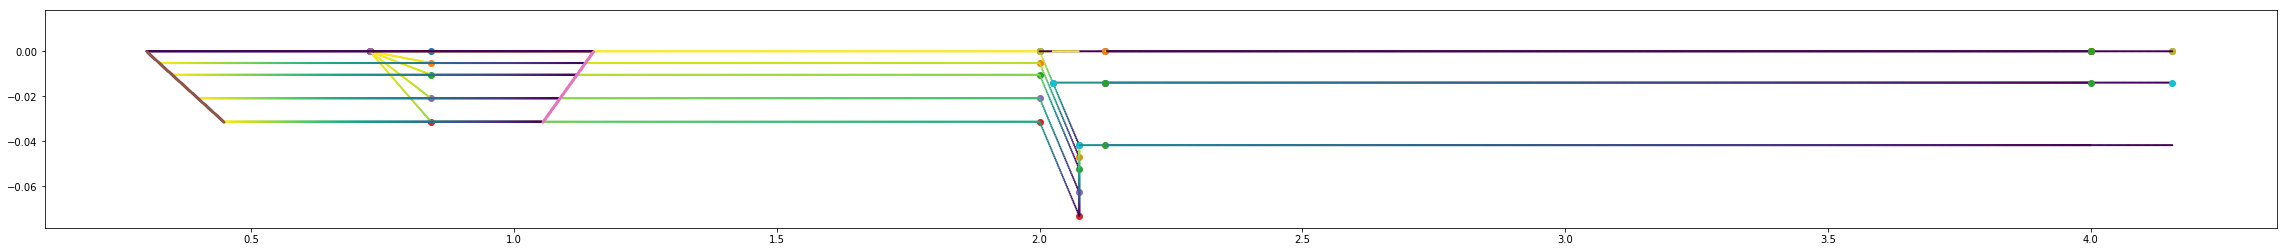

In [3]:
if uw.nProcs()==1:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [40, 4]
    
tracerSwarm=uw.swarm.Swarm(mesh=mesh)
slabshapes=np.array(slabshapes)
slabInCoords= np.array(slabshapes)[:,0:4]
slablast=np.insert(slabshapes[-1][:3:-1],0,slabshapes[-1][0],axis=0)
slabInCoords=np.insert(slabInCoords,-1,slablast,axis=0)
coors=np.array([])
for x in slabInCoords:
    plt.scatter(x[:,0],x[:,1])
    xs=np.linspace(np.min(x[:,0]),np.max(x[:,0]),1000)
    ys=np.interp(xs,x[:,0],x[:,1])
    if uw.nProcs()==1:
        plt.scatter(xs,ys,s=1,c=xs*ys)
    tracerSwarm.add_particles_with_coordinates(np.column_stack((xs,ys)))
last=np.array(slabshapes)[-1,0:-3]


indCoords = np.unique(np.concatenate(np.array(indentorshapes)[:, :, :]), axis=0)
inEp = np.split(indCoords, 2)

for l,r in zip(inEp[0],np.flip(inEp[1],0)):
    xyS=np.stack((np.linspace(l[0],r[0],1000),np.full((1000,),l[1])), axis=-1)
    if uw.nProcs()==1:
        plt.scatter(xyS[:,0],xyS[:,1],s=1,c=xyS[:,0]*xyS[:,1])
    tracerSwarm.add_particles_with_coordinates(xyS)
tip=slabshapes[0,3],slabshapes[-1,-3]
tip=np.stack((np.full((500,),tip[0][0]),(np.linspace(tip[0][1],tip[-1][1],500))), axis=-1)
tracerSwarm.add_particles_with_coordinates(np.column_stack((np.linspace(inEp[0][0][0],inEp[0][-1][0],500),np.linspace(inEp[0][0][1],inEp[0][-1][1],500))));
tracerSwarm.add_particles_with_coordinates(np.column_stack((np.linspace(inEp[1][0][0],inEp[1][-1][0],500),np.linspace(inEp[1][0][1],inEp[1][-1][1],500))));
tracerSwarm.add_particles_with_coordinates(tip);
tincord=tracerSwarm.add_variable(dataType="double", count=2)
tincord.data[:]=tracerSwarm.particleCoordinates.data[:]
if uw.nProcs()==1:
    plt.scatter(np.linspace(inEp[0][0][0],inEp[0][-1][0],500),np.linspace(inEp[0][0][1],inEp[0][-1][1],500),s=1.)
    plt.scatter(np.linspace(inEp[1][0][0],inEp[1][-1][0],500),np.linspace(inEp[1][0][1],inEp[1][-1][1],500),s=1.)
    xyS=tip
    plt.scatter(xyS[:,0],xyS[:,1],s=1,c=xyS[:,0]*xyS[:,1])
    


overRiding=[np.array(overRidingShapesForeArc),np.array(overRidingShapes)]   
for i in overRiding:
    overInCoords= np.array(i)[:,0:4]
    overfirst=np.insert(i[0,0:-2],0,i[-1][0],axis=0)
    overInCoords=np.insert(overInCoords,-1,overfirst,axis=0)
    coors=np.array([])
    for x in overInCoords:
        plt.scatter(x[:,0],x[:,1])
        xs=np.linspace(np.min(x[:,0]),np.max(x[:,0]),1000)
        ys=np.interp(xs,x[:,0],x[:,1])
        if uw.nProcs()==1:
            plt.scatter(xs,ys,s=1,c=xs*ys)
        tracerSwarm.add_particles_with_coordinates(np.column_stack((xs,ys)))



In [ ]:
f=glucifer.Figure(figsize=(1800,200))
f.Points(tracerSwarm,pointsize=4)
f.show()